In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
from tqdm import tqdm
from collections import defaultdict
import gseapy as gp
import anndata
from scipy import stats
from adjustText import adjust_text
from plot_utils import *
from pyscenic.aucell import aucell
import scvi
from ctxcore.genesig import GeneSignature
sns.set_style('whitegrid')

Global seed set to 0


In [4]:
outdir = '../results'
figdir = f'{outdir}/overleaf/figures'
dataset = 'Norman2019'
seed = 0
file = f'../data/{dataset.lower()}/{dataset.lower()}_{seed}.h5ad'

In [5]:
adata = anndata.read_h5ad(file)

In [6]:
adata.obs['control_str'] = adata.obs['control'].astype(str)
adata.obs['control_str'].values

array(['0', '0', '1', ..., '0', '0', '0'], dtype=object)

In [7]:
set(adata.obs['control_str'].values)

{'0', '1'}

#### Enrichment analysis

In [59]:
df = adata.to_df().T
df.index = adata.var.loc[df.index]['gene_name']
adata.obs['control_str'] = adata.obs['control'].astype(str)
res = gp.gsea(data=df.reset_index(), # row -> genes, column-> samples
        gene_sets="GO_Biological_Process_2023",
        cls=adata.obs['control_str'].values,
        permutation_num=500,
        permutation_type='phenotype',
        min_size=5,
        max_size=1000,
        outdir=None,
        method='s2n', # signal_to_noise
        threads= 16)
# res.res2d.to_csv(f'{outdir}/{dataset}_gsea_bp.csv')

/home/vinas/.conda/envs/CPAenv/lib/python3.10/site-packages/gseapy/gsea.py:105: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  df_std = df.groupby(by=cls_dict, axis=1).std(numeric_only=True)


/home/vinas/.conda/envs/CPAenv/lib/python3.10/site-packages/gseapy/plot.py:689: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df[self.colname].replace(
/home/vinas/.conda/envs/CPAenv/lib/python3.10/site-packages/gseapy/plot.py:689: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[self.colname].replace(


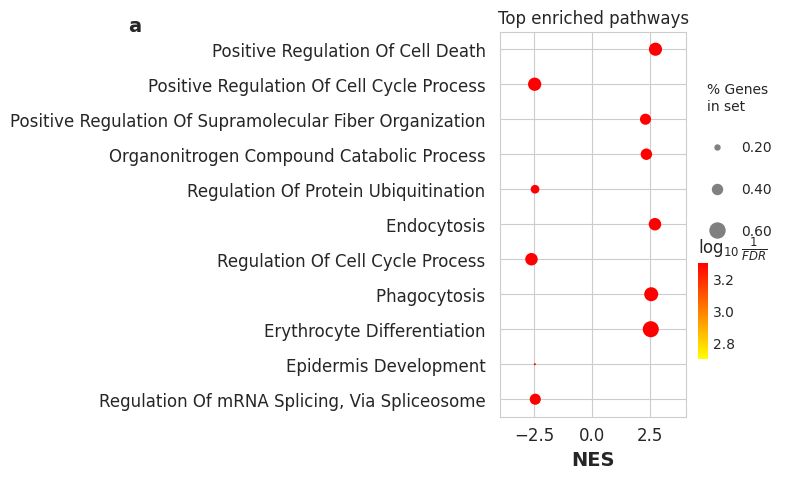

In [65]:
fontsize = 12
res_ = res.res2d.copy()
res_['Term'] = res_['Term'].str.split('(').str[0]
ax = gp.dotplot(res_,
           column='FDR q-val',
           figsize=(3,5),
           title="Enriched stress-related pathways",
           show_ring=False,
           size=3,
           top_term=11,
           cmap = plt.cm.autumn_r)
letter_annotation(ax, -2, 1, 'a', fontsize=14)
plt.yticks(fontsize=fontsize);
plt.xticks(fontsize=fontsize);
plt.xlabel('NES', fontsize=14);
plt.title('Top enriched pathways', fontsize=12);
plt.savefig(f'{figdir}/{dataset}_top_pathway_enrichment_fd.pdf', bbox_inches='tight');

In [19]:
res_['Term'].str.replace('Positive', 'Pos.').str.replace('Regulation', 'Reg.')

0                                Pos. Reg. Of Cell Death 
1                                            Endocytosis 
2                             Reg. Of Cell Cycle Process 
3                                           Phagocytosis 
4                            Erythrocyte Differentiation 
                              ...                        
2038                                     Cilium Movement 
2039                     Canonical Wnt Signaling Pathway 
2040                       Reg. Of Lymphocyte Activation 
2041                             Muscle Cell Development 
2042    Pos. Reg. Of Granulocyte Macrophage Colony-Sti...
Name: Term, Length: 2043, dtype: object

/home/vinas/.conda/envs/CPAenv/lib/python3.10/site-packages/gseapy/plot.py:689: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df[self.colname].replace(
/home/vinas/.conda/envs/CPAenv/lib/python3.10/site-packages/gseapy/plot.py:689: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[self.colname].replace(


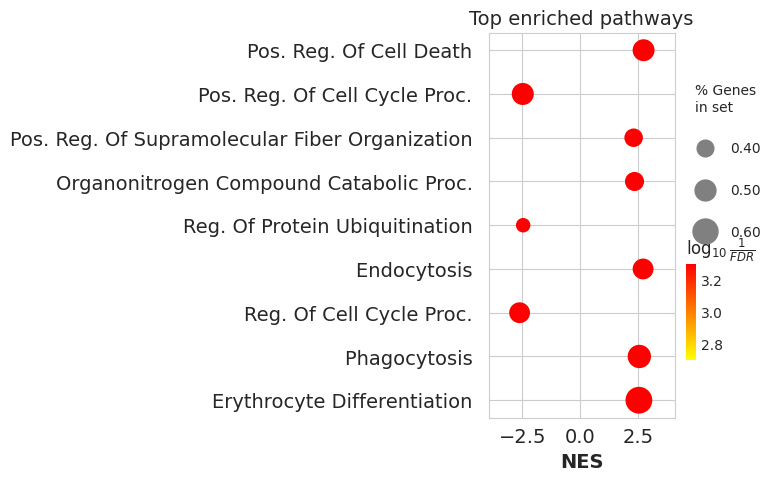

In [21]:
fontsize = 14
# res_ = res.res2d.copy()
res_ = pd.read_csv(f'{outdir}/{dataset}_gsea_bp.csv', index_col=0)
res_['Term'] = res_['Term'].str.split('(').str[0]
res_['Term'] = res_['Term'].str.replace('Positive', 'Pos.').str.replace('Regulation', 'Reg.').str.replace('Process', 'Proc.')
ax = gp.dotplot(res_,
           column='FDR q-val',
           figsize=(3, 5),
           title="Enriched stress-related pathways",
           show_ring=False,
           size=5,
           top_term=9,
           cmap = plt.cm.autumn_r)
# letter_annotation(ax, -2, 1, 'a', fontsize=14)
plt.yticks(fontsize=fontsize);
plt.xticks(fontsize=fontsize);
plt.xlabel('NES', fontsize=14);
plt.title('Top enriched pathways', fontsize=14);
plt.savefig(f'{figdir}/{dataset}_top_pathway_enrichment_fd_2_abrv.pdf', bbox_inches='tight');

In [96]:
# Select specific pathways
# keywords = ['heat', 'unfolded', 'dna damage', 'cell death', 'oxidative', 'stress', 'autophagy', 'apopt', 'external']
keywords = ['heat', 'unfolded', 'cell death', 'stress']
m = [any([k in x.lower() for k in keywords]) for x in res.res2d['Term'].values]
selected_pathways = np.unique(res.res2d['Term'].values[m])
res_selected = res.res2d[res.res2d['Term'].isin(selected_pathways)]

AttributeError: 'DataFrame' object has no attribute 'res2d'

In [30]:
res_selected_ = res_selected.copy()
res_selected_['Term'] = res_selected_['Term'].str.split('(').str[0]
ax = gp.dotplot(res_selected_,
           column='FDR q-val',
           figsize=(3,5),
           title="Enriched stress-related pathways",
           show_ring=False,
           size=3,
           top_term=20,
           cmap = plt.cm.autumn_r)
letter_annotation(ax, -2, 1, 'b', fontsize=14)
# plt.ylabel(plt.gca().yaxis.get_label(), fontsize=4)
plt.yticks(fontsize=fontsize);
plt.xticks(fontsize=fontsize);
plt.xlabel('NES', fontsize=14);
plt.title('Enriched stress-related pathways', fontsize=12)
plt.savefig(f'{figdir}/{dataset}_stress_pathway_enrichment_fd.pdf', bbox_inches='tight');

NameError: name 'res_selected' is not defined

#### Volcano plots

In [6]:
# res_df = res.res2d
res_df = pd.read_csv(f'{outdir}/{dataset}_gsea_bp.csv')

In [7]:
pvals = []
X = adata.layers['counts']
# X = 1e6 * X / X.sum(axis=1)[:, None]
X = np.log1p(X)
X_ctl = X[adata.obs['control'] == 1]
X_pert = X[adata.obs['control'] == 0]
for i in tqdm(range(adata.shape[-1])):
    t_statistic, p_values = stats.ttest_ind(X_pert[:, i], X_ctl[:, i])
    pvals.append(p_values)
pvals = np.array(pvals)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5045/5045 [00:05<00:00, 935.39it/s]


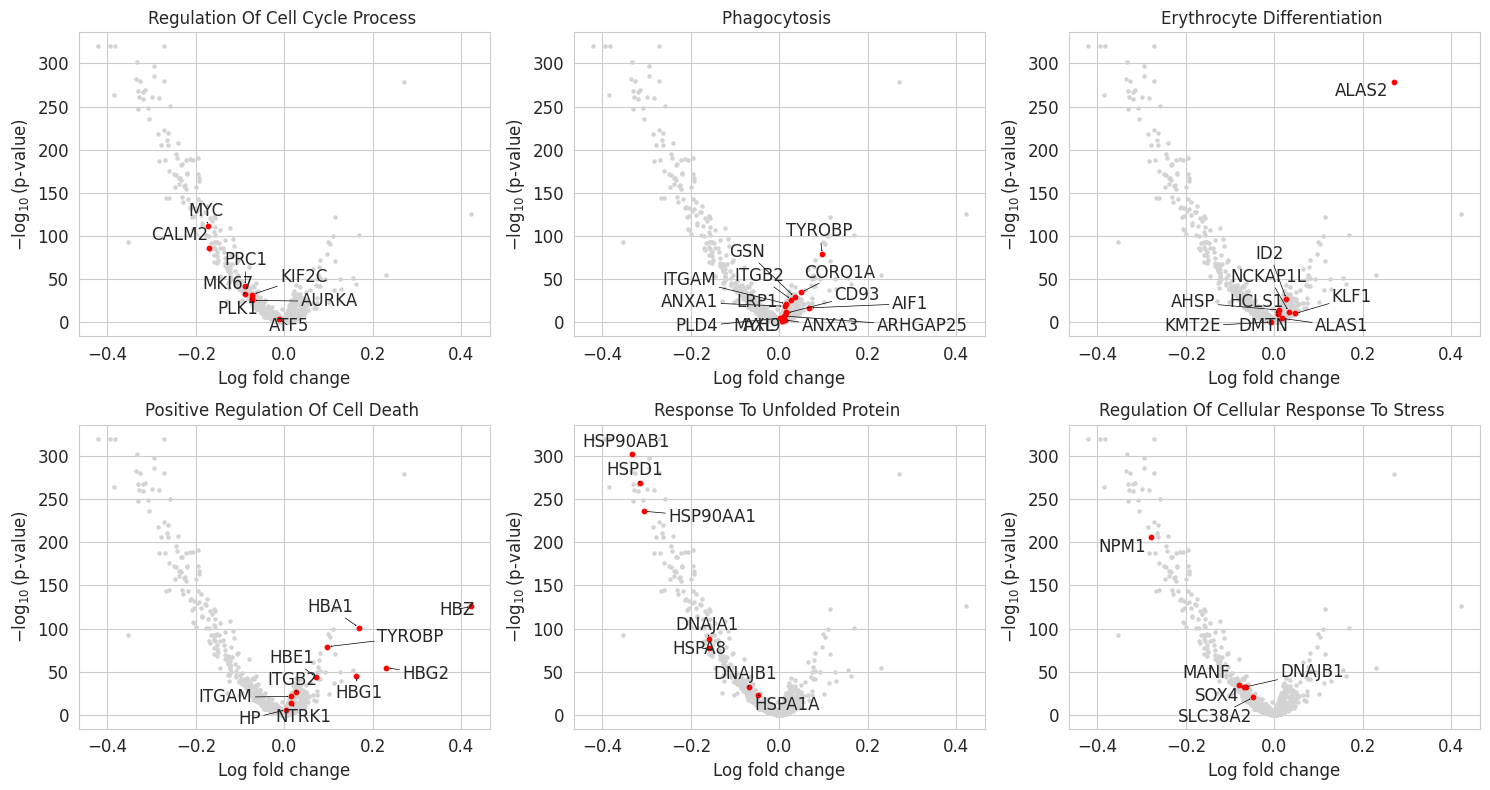

In [8]:
idxs = [2, 3, 4, 0, 44, 119]
nrows = 2
ncols = 3
fontsize=12
eps = 1e-320

x = X_pert.mean(0) - X_ctl.mean(0)
y = -np.log10(pvals + eps)
gene_names = adata.var['gene_name']
res_ = res_df # res.res2d.copy()
res_['Term'] = res_['Term'].str.split('(').str[0]
fig = plt.figure(figsize=(ncols*5, nrows*4))
for i, idx in enumerate(idxs):
    row = res_.loc[idx]
    plt.subplot(nrows, ncols, i+1)
    # letter_annotation(plt.gca(), -.1, 1, chr(97 + i), fontsize=14)
    volcano_plot(x, y, row, gene_names, fontsize=fontsize)
plt.tight_layout()
plt.savefig(f'{figdir}/{dataset}_volcano_combined_all.pdf', bbox_inches='tight');

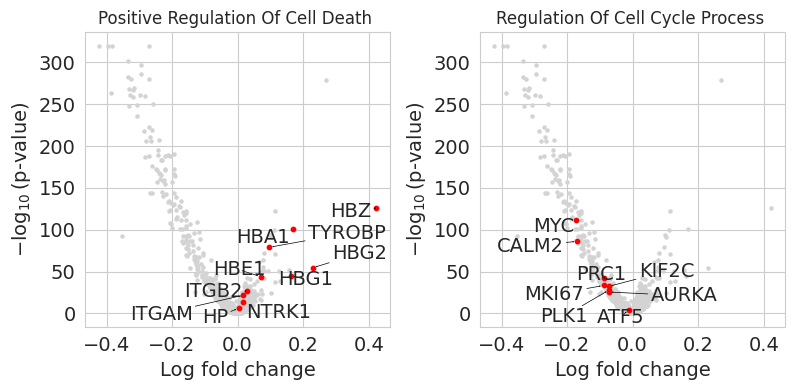

In [28]:
idxs = [0, 2]  # 4
nrows = 1
ncols = 3
fontsize=16
eps = 1e-320

x = X_pert.mean(0) - X_ctl.mean(0)
y = -np.log10(pvals + eps)
gene_names = adata.var['gene_name']
res_ = res_df # res.res2d.copy()
res_['Term'] = res_['Term'].str.split('(').str[0]
fig = plt.figure(figsize=(ncols*4, nrows*4))
for i, idx in enumerate(idxs):
    row = res_.loc[idx]
    plt.subplot(nrows, ncols, i+1)
    # letter_annotation(plt.gca(), -.1, 1, chr(99 + i), fontsize=14)
    volcano_plot(x, y, row, gene_names, fontsize=14)
plt.tight_layout()
plt.savefig(f'{figdir}/{dataset}_volcano_combined_2.pdf', bbox_inches='tight');

In [ ]:
# Recycling bin
pert_mean_2 = np.zeros_like(pert_mean)
pert_mean_2
conditions = set(adata.obs['condition'].unique()) - set(['ctrl'])
for condition in conditions:
    adata_condition = adata[adata.obs["condition"] == condition]
    pert_mean_2 += np.array(adata_condition.X.mean(axis=0))[0]
pert_mean_2 = pert_mean_2 / len(conditions)

#### Analyze perturbation directions

In [52]:
train_adata = adata[adata.obs['split'] == 'train']
control_adata = train_adata[train_adata.obs['control'] == 1]
pert_adata = train_adata[train_adata.obs['control'] == 0]
control_mean = np.array(control_adata.X.mean(axis=0))[0]
pert_mean = np.array(pert_adata.X.mean(axis=0))[0]
avg_shift = pert_mean-control_mean

In [134]:
def get_perturbation_shifts(adata, reference, top_20=False):
    pert_shifts = []
    conditions = set(adata.obs['condition'].unique()) - set(['ctrl'])
    for condition in conditions:
        adata_condition = adata[adata.obs["condition"] == condition]
        pert_shift = np.array(adata_condition.X.mean(axis=0))[0] - reference
        
        if top_20:
            # Select top 20 DE genes
            top20_de_idxs = adata.uns["top_non_dropout_de_20"][
                adata_condition.obs["condition_name"].values[0]
            ]
            top20_de_idxs = np.argwhere(
                np.isin(adata.var.index, top20_de_genes)
            ).ravel()
            pert_shift = pert_shift[top20_de_idxs]

        # Compute shift
        pert_shifts.append(pert_shift)
    return np.array(pert_shifts)

def calculate_cosine_similarities(pert_shifts, reference):
    sims = cosine_similarity(pert_shifts, reference[None, :]).ravel()
    return sims

def calculate_pairwise_cosine_similarities(pert_shifts):
    sims = cosine_similarity(np.array(pert_shifts))
    return sims[np.triu_indices(len(sims), k=1)]

In [135]:
pert_shifts = {
    'avg_ctl': get_perturbation_shifts(adata, reference=control_mean),
    'avg_pert': get_perturbation_shifts(adata, reference=pert_mean)
}

similarities = {}
for k, v in pert_shifts.items():
    similarities[k] = calculate_cosine_similarities(v, avg_shift)
    
pairwise_similarities = {}
for k, v in pert_shifts.items():
    pairwise_similarities[k] = calculate_pairwise_cosine_similarities(v)

<Axes: xlabel='type', ylabel='value'>

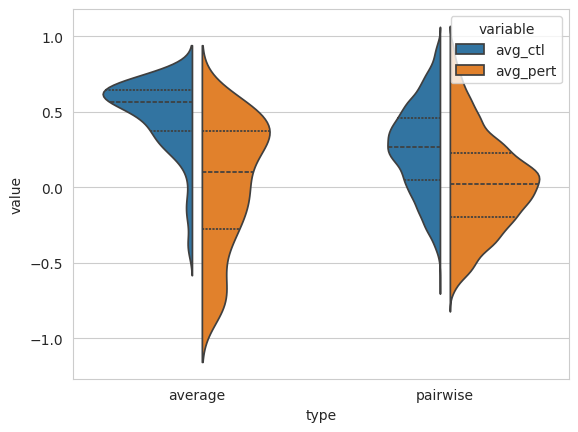

In [145]:
df = pd.DataFrame(similarities).melt()
df['type'] = 'average'

df_pair = pd.DataFrame(pairwise_similarities).melt()
df_pair['type'] = 'pairwise'

df = pd.concat([df, df_pair])

sns.violinplot(data=df, x='type', y='value', hue='variable', split=True, inner="quart", gap=.1)

In [120]:
sns.histplot(similarities)

In [98]:
similarities = cosine_similarity(np.array(pert_shifts))
similarities

array([[ 1.0000006 ,  0.87790257, -0.03403424, ...,  0.5132504 ,
         0.54033995,  0.16781679],
       [ 0.87790257,  1.0000006 ,  0.10922673, ...,  0.47930077,
         0.57900375,  0.27242804],
       [-0.03403424,  0.10922673,  1.0000012 , ..., -0.11129082,
         0.17036678,  0.5751683 ],
       ...,
       [ 0.5132504 ,  0.47930077, -0.11129082, ...,  1.0000004 ,
         0.39230537, -0.11030439],
       [ 0.54033995,  0.57900375,  0.17036678, ...,  0.39230537,
         1.0000005 ,  0.36424682],
       [ 0.16781679,  0.27242804,  0.5751683 , ..., -0.11030439,
         0.36424682,  1.000001  ]], dtype=float32)

<Axes: ylabel='Count'>

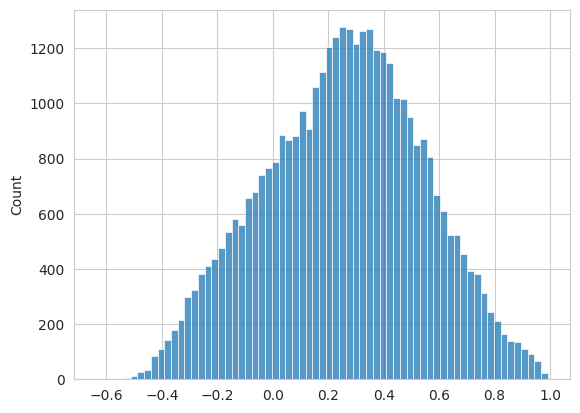

In [99]:
sns.histplot(similarities[np.triu_indices(len(similarities), k=1)])

In [108]:
avg_shift = pert_mean - control_mean

distances = []
pert_shifts = []
conditions = adata.obs['condition'].unique()
for condition in conditions:
    adata_condition = adata[adata.obs["condition"] == condition]
    pert_shift = np.array(adata_condition.X.mean(axis=0))[0] - pert_mean
    pert_shifts.append(pert_shift)
    d = cosine(pert_shift, avg_shift)
    distances.append(d)

<Axes: ylabel='Count'>

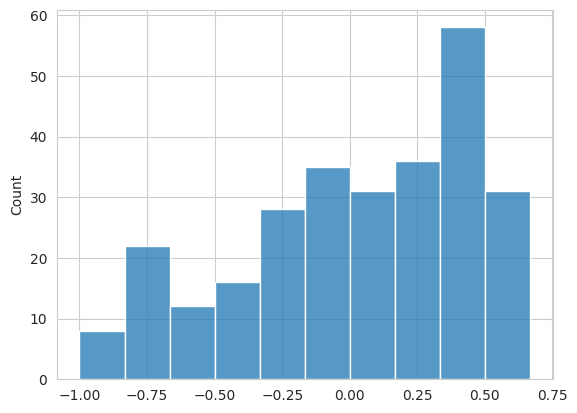

In [109]:
sns.histplot(1 - np.array(distances))

In [101]:
similarities = cosine_similarity(np.array(pert_shifts))
similarities

array([[ 1.0000011 ,  0.07918227,  0.5292286 , ...,  0.12665652,
        -0.08214118, -0.14168194],
       [ 0.07918227,  1.0000006 ,  0.33484802, ...,  0.04541082,
        -0.00137099, -0.41427732],
       [ 0.5292286 ,  0.33484802,  1.0000013 , ..., -0.01005081,
        -0.4027805 , -0.3580632 ],
       ...,
       [ 0.12665652,  0.04541082, -0.01005081, ...,  1.0000007 ,
         0.72512794,  0.03826571],
       [-0.08214118, -0.00137099, -0.4027805 , ...,  0.72512794,
         1.0000011 ,  0.18689494],
       [-0.14168194, -0.41427732, -0.3580632 , ...,  0.03826571,
         0.18689494,  1.0000011 ]], dtype=float32)

<Axes: ylabel='Count'>

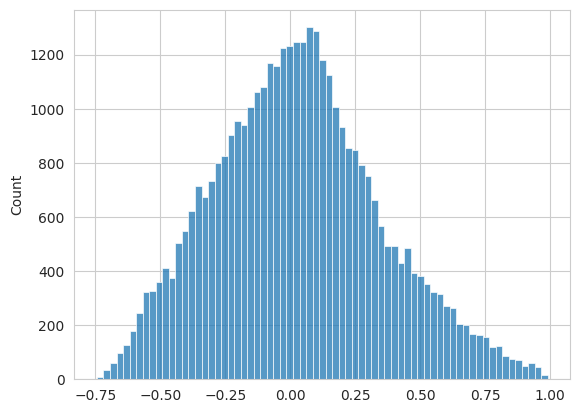

In [93]:
sns.histplot(similarities[np.triu_indices(len(similarities), k=1)])

In [110]:
np.mean(similarities[np.triu_indices(len(similarities), k=1)])

0.029156992

#### Score cells

In [107]:
enr_results_df = pd.read_csv(f'{outdir}/{dataset}_gsea_bp.csv', index_col=0)

In [119]:
keywords = ['heat', 'unfolded', 'cell death', 'stress']
m = [any([k in x.lower() for k in keywords]) for x in enr_results_df['Term'].values]
selected_pathways = np.unique(enr_results_df['Term'].values[m])
selected_pathways

array(['Cellular Response To Chemical Stress (GO:0062197)',
       'Cellular Response To Heat (GO:0034605)',
       'Cellular Response To Osmotic Stress (GO:0071470)',
       'Cellular Response To Oxidative Stress (GO:0034599)',
       'Cellular Response To Unfolded Protein (GO:0034620)',
       'Integrated Stress Response Signaling (GO:0140467)',
       'Intrinsic Apoptotic Signaling Pathway In Response To Endoplasmic Reticulum Stress (GO:0070059)',
       'Negative Regulation Of Programmed Cell Death (GO:0043069)',
       'Negative Regulation Of Response To Endoplasmic Reticulum Stress (GO:1903573)',
       'Negative Regulation Of Stress-Activated MAPK Cascade (GO:0032873)',
       'Positive Regulation Of Cell Death (GO:0010942)',
       'Positive Regulation Of Programmed Cell Death (GO:0043068)',
       'Positive Regulation Of Response To Endoplasmic Reticulum Stress (GO:1905898)',
       'Positive Regulation Of Stress Fiber Assembly (GO:0051496)',
       'Positive Regulation Of Str

In [133]:
selected_pathways = [
    'Positive Regulation Of Cell Death (GO:0010942)',
    'Endocytosis (GO:0006897)',
    'Phagocytosis (GO:0006909)',
    'Regulation Of Cell Cycle Process (GO:0010564)',
    'Erythrocyte Differentiation (GO:0030218)',
    'Response To Unfolded Protein (GO:0006986)',
    'Regulation Of Cellular Response To Stress (GO:0080135)',
    'Cellular Response To Chemical Stress (GO:0062197)'
]

In [134]:
gene_signatures = []
for p in selected_pathways:
    lead_genes = enr_results_df[enr_results_df['Term'] == p]['Lead_genes'].values[0]
    lead_genes_dict = {k: 1 for k in lead_genes.split(';')}
    sig = GeneSignature(name=p, gene2weight=lead_genes_dict)
    gene_signatures.append(sig)

In [122]:
expr = adata.to_df()
expr.columns = adata.var.loc[expr.columns]['gene_name']

In [135]:
auc_mtx = aucell(expr, gene_signatures)

In [136]:
auc_mtx['control'] = adata.obs.loc[auc_mtx.index]['control']

([0, 1, 2, 3, 4, 5, 6, 7],
 [Text(0, 0, 'Positive Regulation Of Cell Death '),
  Text(1, 0, 'Endocytosis '),
  Text(2, 0, 'Phagocytosis '),
  Text(3, 0, 'Regulation Of Cell Cycle Process '),
  Text(4, 0, 'Erythrocyte Differentiation '),
  Text(5, 0, 'Response To Unfolded Protein '),
  Text(6, 0, 'Regulation Of Cellular Response To Stress '),
  Text(7, 0, 'Cellular Response To Chemical Stress ')])

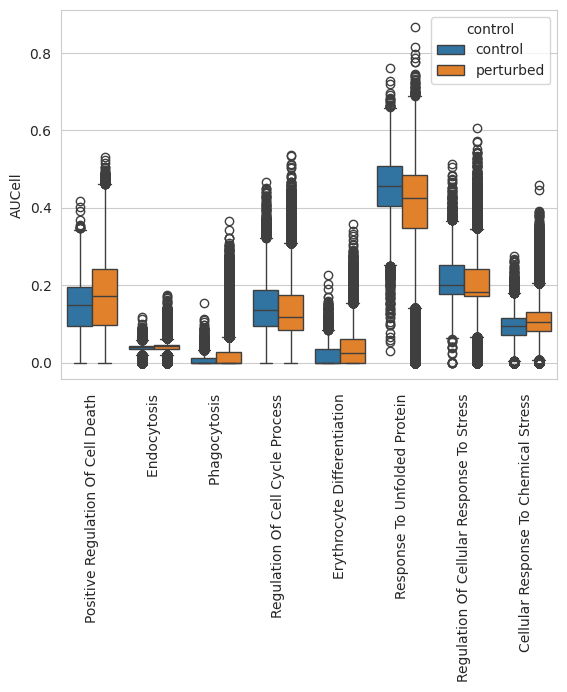

In [199]:
df = auc_mtx.melt(id_vars=['control'])
df['control'] = df['control'].replace({1: 'control', 0: 'perturbed'})
df['Regulon'] = df['Regulon'].str.split('(').str[0]
sns.boxplot(data=df,
            x='Regulon',
            y='value',
            hue='control',
            hue_order=['control', 'perturbed'])

"""
pairs = [
    (("Positive Regulation Of Cell Death ", "control"), ("Positive Regulation Of Cell Death ", "perturbed")),
]

for name,ax in g.axes_dict.items():
# subset the table otherwise the stats were calculated on the whole dataset
        annot = Annotator(ax, pairs, )  # **args,data=tips.loc[tips['time']==name,:] 
        annot.configure(test='Mann-Whitney', text_format='simple', loc='inside', verbose=2)
        annot.apply_test().annotate()
"""

plt.ylabel('AUCell')
plt.xlabel('')
plt.xticks(rotation=90)

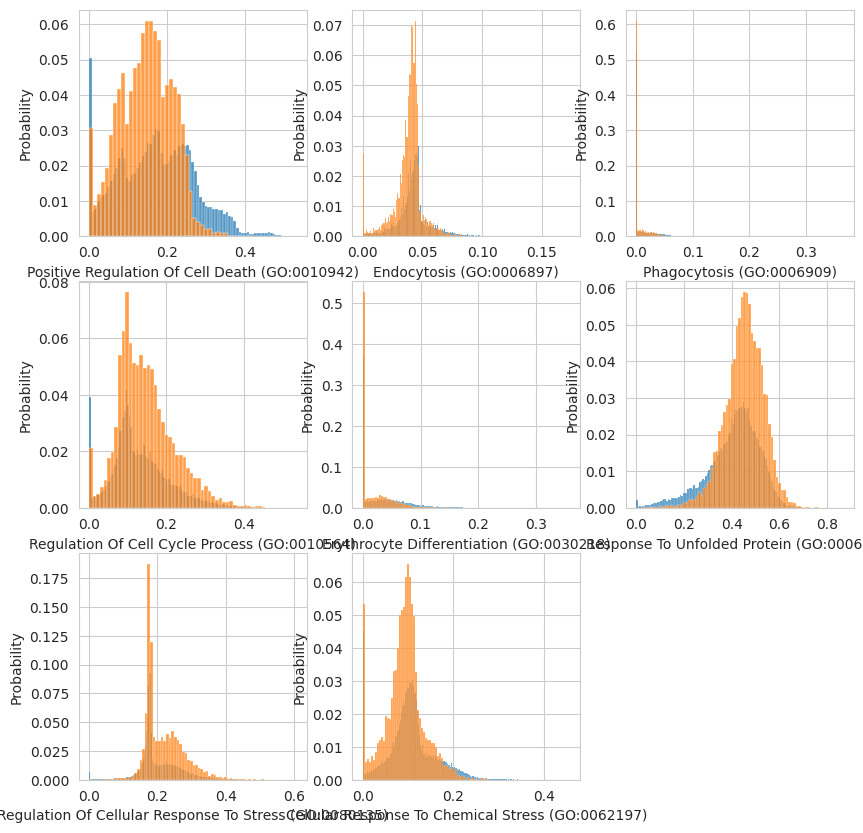

In [176]:
plt.figure(figsize=(10, 10))
for i, p in enumerate(selected_pathways):
    plt.subplot(3, 3, i+1)
    sns.histplot(auc_mtx[auc_mtx['control'] == 0][p], stat='probability')
    sns.histplot(auc_mtx[auc_mtx['control'] == 1][p], stat='probability')

In [63]:
scvi.model.SCVI.setup_anndata(
    adata,
    layer="counts",
    # categorical_covariate_keys=["cell_source", "donor"],
    # continuous_covariate_keys=["percent_mito", "percent_ribo"],
)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [64]:
model = scvi.model.SCVI(adata)

In [65]:
model.train()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 90/90: 100%|█████████████████████████████████████████████████████████| 90/90 [08:47<00:00,  5.68s/it, loss=1.1e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=90` reached.


Epoch 90/90: 100%|█████████████████████████████████████████████████████████| 90/90 [08:47<00:00,  5.86s/it, loss=1.1e+03, v_num=1]


In [66]:
SCVI_LATENT_KEY = "X_scVI"

latent = model.get_latent_representation()
adata.obsm[SCVI_LATENT_KEY] = latent

In [76]:
# run PCA then generate UMAP plots
sc.tl.pca(adata)
sc.pp.neighbors(adata, n_pcs=30, n_neighbors=20)
sc.tl.umap(adata, min_dist=0.3)

In [138]:
for p in selected_pathways:
    adata.obs[p] = auc_mtx.loc[adata.obs.index][p]

In [139]:
adata.obs['control_str'] = adata.obs['control'].astype(str)

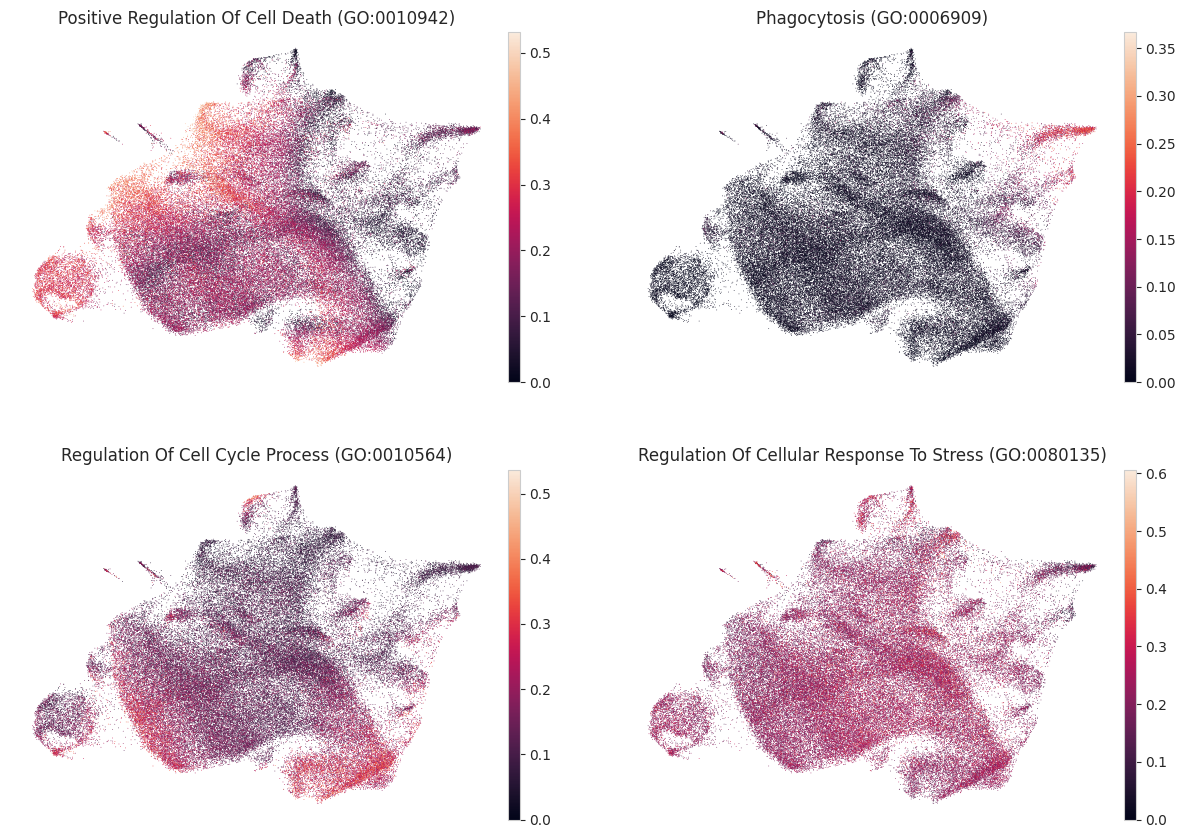

In [146]:
sc.pl.umap(
    adata,
    color=np.array(selected_pathways)[[0, 2, 3, 6]],
    ncols=2,
    frameon=False,
)

/home/vinas/.conda/envs/CPAenv/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/vinas/.conda/envs/CPAenv/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


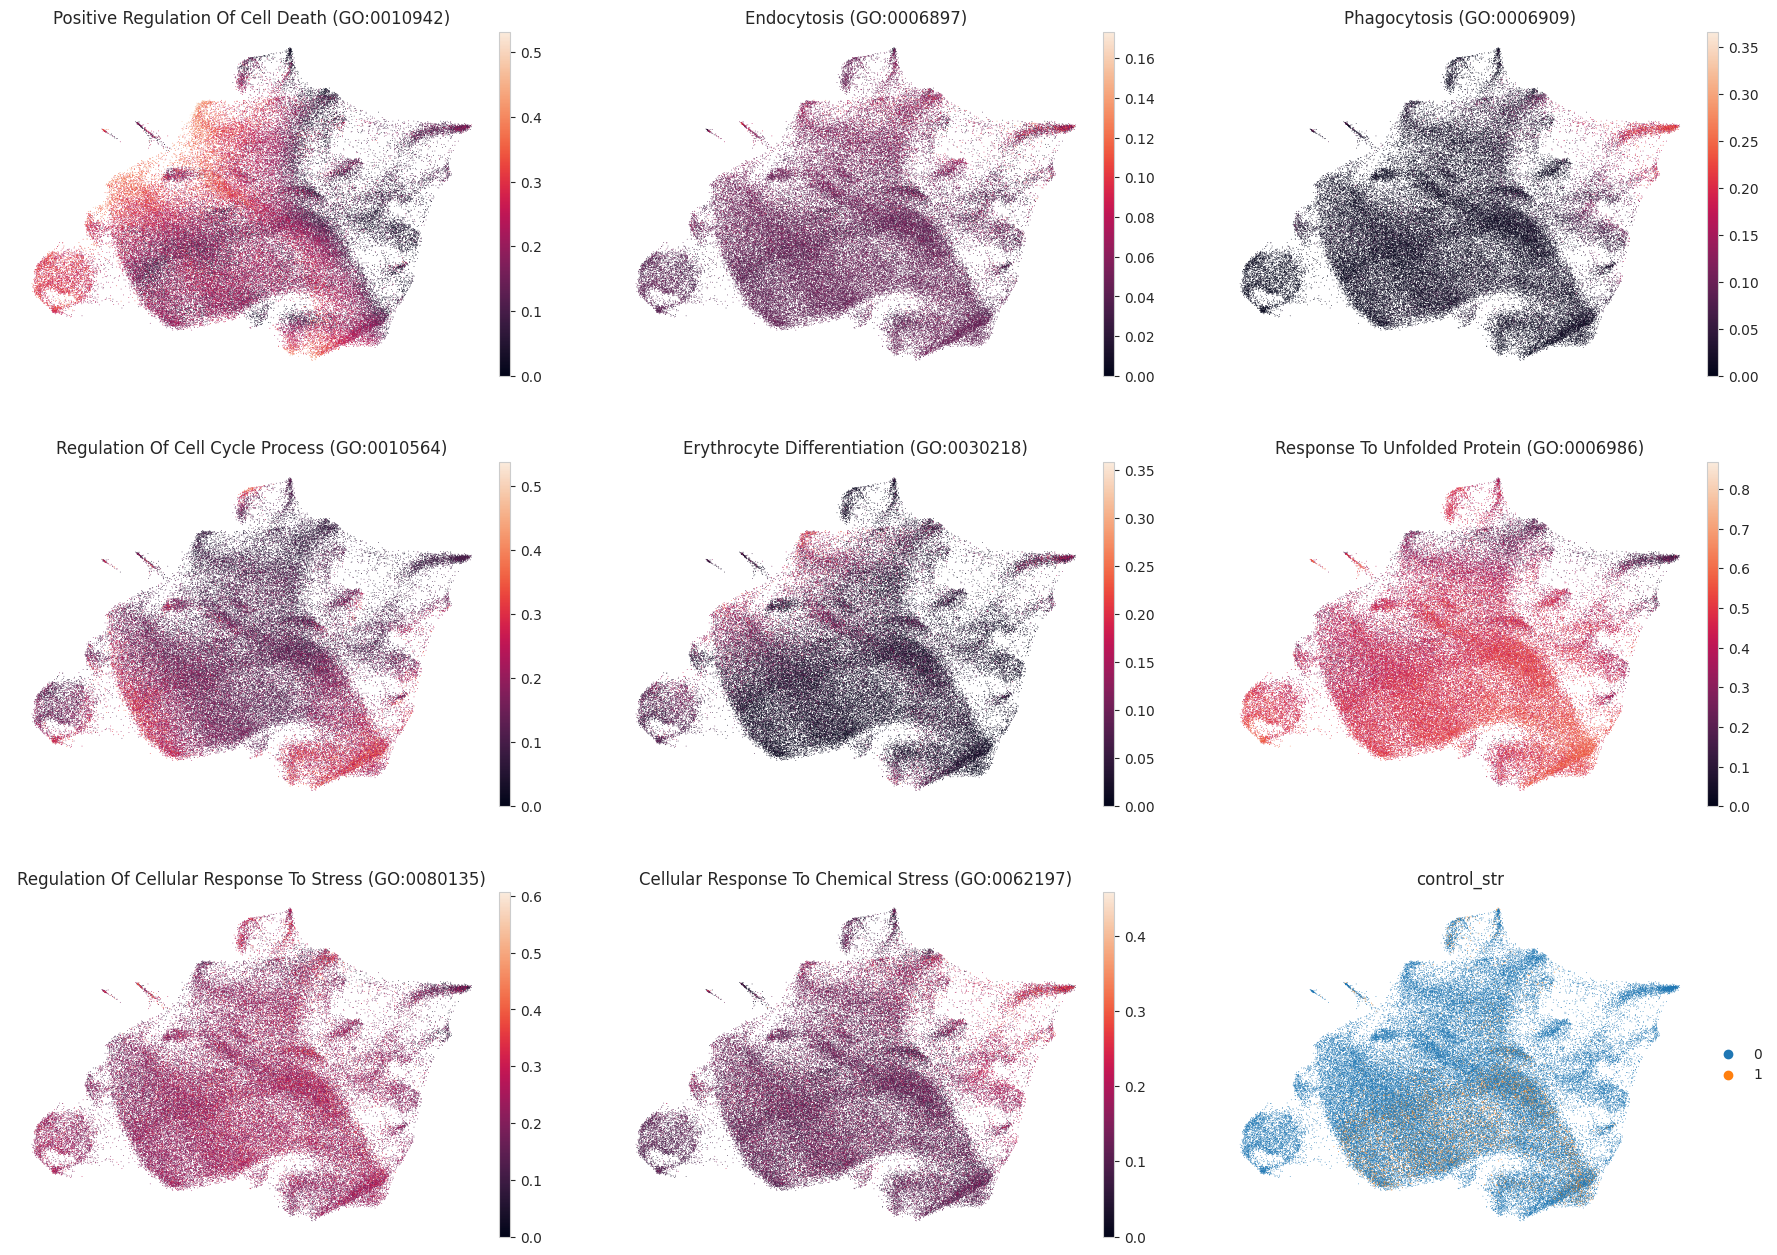

In [140]:
sc.pl.umap(
    adata,
    color=selected_pathways + ['control_str'],
    ncols=3,
    frameon=False,
)

In [147]:
# use scVI latent space for UMAP generation
sc.pp.neighbors(adata, use_rep=SCVI_LATENT_KEY)
sc.tl.umap(adata, min_dist=0.3)

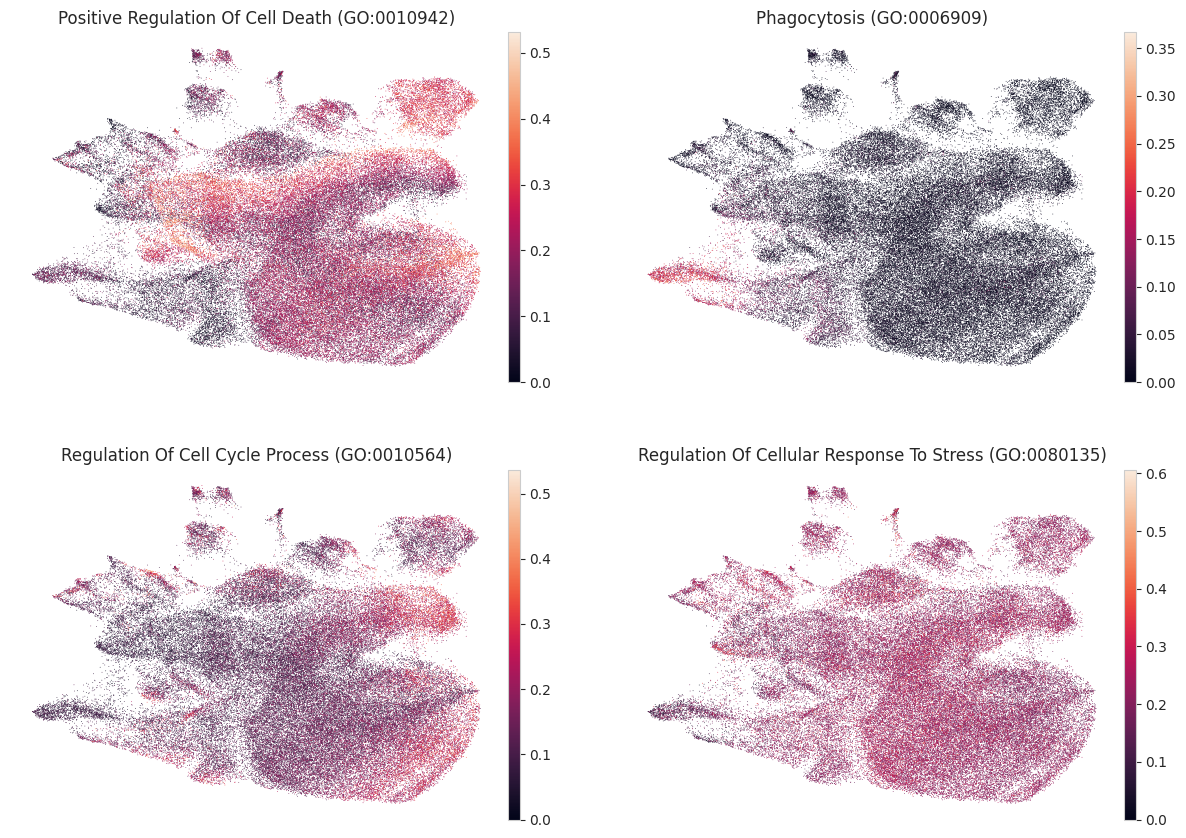

In [148]:
sc.pl.umap(
    adata,
    color=np.array(selected_pathways)[[0, 2, 3, 6]],
    ncols=2,
    frameon=False,
)